<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/8_Ultra_Pro_%D0%9F%D0%BE%D0%BB%D0%BD%D0%BE%D1%81%D0%B2%D1%8F%D0%B7%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8%2C_%D0%BE%D0%B1%D1%83%D1%87%D0%B0%D1%8E%D1%89%D0%B0%D1%8F_%D0%B8_%D1%82%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%B0%D1%8F_%D0%B2%D1%8B%D0%B1%D0%BE%D1%80%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra pro

Макс 10 баллов

По подготовленным на занятии данным, создайте обучающую, тестовую и проверочную выборки. 

По сформированным данным необходимо обучить модель для предсказания цены машины. Оцените качество работы созданной сети, определив средний процент ошибки на проверочной выборке. (Для этого потребуется привести предсказанные моделью значения к первоначальному диапазону цен. Это можно сделать с помощью следующего метода:

predict_inverse = y_scaler.inverse_transform(predict).flatten()

где predict - результат предсказания модели).

Затем подсчитайте среднюю ошибку на тестовой выборке, среднюю цену и средний процент ошибки.

Рекомендации:

В качестве ошибки рекомендуется использовать среднеквадратическую ошибку (mse).
Метрику для данной задачи можно не использовать.
Последний слой модели должен иметь 1 нейрон.

In [ ]:
from tensorflow.keras.models import Sequential # НС прямого распространения
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization # Основные слои
from tensorflow.keras import utils # Утилиты для to_categorical
from tensorflow.keras.preprocessing import image # Для отрисовки изображения
from tensorflow.keras.optimizers import Adam, Adadelta # Алгоритмы оптимизации, для настройки скорости обучения
import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Отрисовка изображений
from PIL import Image # Отрисовка изображений
import pandas as pd # Библиотека pandas
from google.colab import files # Импорт файлов
from sklearn.preprocessing import LabelEncoder, StandardScaler # Функции для нормализации данных
from sklearn import preprocessing # Пакет предварительной обработки данных

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline


In [ ]:
# Загружаем файлы
files.upload()
!ls # Выводим содержимое корневой папки

Saving cars_new.csv to cars_new.csv
cars_new.csv  sample_data


In [ ]:
# Загружаем данные из файла 
cars = pd.read_csv("cars_new.csv", sep=',')   
cars.head()                                    # Выводим первые 5 строк наших данных

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [ ]:
print(cars.values.shape) # Размерность данных

(70119, 10)


In [ ]:
# Создаём словарь поле - его индекс
def create_dict(s):
  ret = {}                          # Создаём пустой словарь
  for _id, name in enumerate(s):    # Проходим по всем парам - id и название
    ret.update({name: _id})         # Добавляем в словарь
  return ret

# Функция преобразования в one hot encoding
def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [ ]:
# Создаём словари по всем текстовым колонкам
marks_dict = create_dict(set(cars['mark']))
models_dict = create_dict(set(cars['model']))
bodies_dict = create_dict(set(cars['body']))
kpps_dict = create_dict(set(cars['kpp']))
fuels_dict = create_dict(set(cars['fuel']))

# Запоминаем цены
prices = np.array(cars['price'], dtype=np.float)

# Запоминаем числовые параметры
# и нормируем
years = preprocessing.scale(cars['year'])
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

In [ ]:
print(marks_dict)

{'volkswagen': 0, 'ford': 1, 'audi': 2, 'skoda': 3, 'mitsubishi': 4, 'hyundai': 5, 'opel': 6, 'mercedes-benz': 7, 'toyota': 8, 'chery': 9, 'daewoo': 10, 'kia': 11, 'renault': 12, 'subaru': 13, 'honda': 14, 'nissan': 15, 'bmw': 16, 'suzuki': 17, 'peugeot': 18, 'chevrolet': 19, 'mazda': 20}


In [ ]:
years.mean()

7.129646144783743e-15

In [ ]:
years.std()

1.0

In [ ]:
print(powers)

[ 0.22905575 -0.95630346 -0.87163494 ...  0.22905575 -0.75309902
  2.34576862]


In [ ]:
# Создаём пустую обучающую выборку
x_train = []
y_train = []

# Проходим по всем машинам
for _id, car in enumerate(np.array(cars)):
  # В y_train добавляем цену
  y_train.append(prices[_id])
  
  # В x_train объединяем все параметры
  # Категорийные параметры добавляем в виде ohe
  # Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  # Добавляем текущую строку в общий x_train
  x_train.append(x_tr)

# Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)

In [ ]:
# Выводим размеры выборок
print(x_train.shape)
print(y_train.shape)

(70119, 3208)
(70119,)


In [ ]:
# Выводим один x_train
print(x_train[0,:20])
print(x_train[0,-20:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  1.          0.          0.          0.          1.5200145  -1.40018212
  0.12288486  0.22905575]


In [ ]:
# Выводим y_train
print(y_train[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]


In [ ]:
# Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

# y_train.reshape(-1,1) добавляет одну размерность
# Это нужно потому, что y_scaler.fit_transform
# Требует двумерный вектор, массив примеров, которые надо нормализовать
# Он не умеет работать с одним примером
# Поэтому мы делаем массив из одного примера
# На выходе он так же выдаёт массив примеров
# Но нам нужен только первый пример
# Поэтому мы делаем flatten() - уменьшение размерности

In [ ]:
y_train_scaled.shape

(70119,)

In [ ]:
# Выводим базовый и нормированный y_train
print(y_train[:10])
print(y_train_scaled[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]
[ 0.75082432 -0.62135434  0.3563911   0.70913625 -0.51745486  0.73318706
  0.09824578 -0.04445567  1.27032173 -0.4132347 ]


In [ ]:
# Cоздаeм обучающую, тестовую выборки. 

from sklearn.model_selection import train_test_split

# test_size=0.2 - будет выделено 20% от тренировочных данных 
# shuffle=True - перемешать данные
# x_train - данные для обучения
# x_test - данные для проверки
# y_train - правильные ответы для обучения
# y_test - правильные ответы для проверки
x_train, x_test, y_train_scaled, y_test_scaled = train_test_split(x_train, y_train_scaled, test_size=0.1, shuffle=True)    
print (x_train.shape)
print (x_test.shape)
print (y_train_scaled.shape)
print (y_test_scaled.shape)

(63107, 3208)
(7012, 3208)
(63107,)
(7012,)


In [ ]:
# Cоздаeм проверочную выборку из обучающей выборки
x_train_new, x_val, y_train_new, y_val = train_test_split(x_train,
                                                          y_train_scaled,
                                                          test_size=0.1)

# Выводим размеры полученных выборок
print(x_train_new.shape)
print(x_val.shape)
print(y_train_new.shape)
print(y_val.shape)


(56796, 3208)
(6311, 3208)
(56796,)
(6311,)


Итого мы имеем три набора данных:

Обучающий набор данных = x_train_new , y_train_new

Проверочный набор данных = x_val , y_val

Тестовый набор данных = x_test, y_test_scaled

In [ ]:
y_train_new.min()

-0.8204950196272253

In [ ]:
y_train_new.max()

38.436834251852716

In [ ]:
# Обучаем модель

model_ula = Sequential()
model_ula.add(Dense(32, input_dim=x_train_new.shape[1], activation='relu'))
model_ula.add(Dropout(0.2))
model_ula.add(Dense(16,  activation='tanh'))
model_ula.add(Dropout(0.2))
model_ula.add(Dense(1, activation='linear'))

model_ula.compile(loss='mse', optimizer=Adam(0.01))
# model_ula.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
# model_ula.compile(optimizer = Adam(0.0001), loss = 'mse',metrics=['mae'])

# training
history=model_ula.fit(x_train_new, y_train_new, epochs = 30, batch_size = 2048, validation_data=(x_val, y_val))



Epoch 1/30
28/28 [==============================] - 2s 42ms/step - loss: 0.4108 - val_loss: 0.1255
Epoch 2/30
28/28 [==============================] - 1s 37ms/step - loss: 0.2246 - val_loss: 0.0700
Epoch 3/30
28/28 [==============================] - 1s 37ms/step - loss: 0.1880 - val_loss: 0.0570
Epoch 4/30
28/28 [==============================] - 1s 37ms/step - loss: 0.1663 - val_loss: 0.0586
Epoch 5/30
28/28 [==============================] - 1s 37ms/step - loss: 0.1561 - val_loss: 0.0550
Epoch 6/30
28/28 [==============================] - 1s 37ms/step - loss: 0.1480 - val_loss: 0.0536
Epoch 7/30
28/28 [==============================] - 1s 38ms/step - loss: 0.1371 - val_loss: 0.0548
Epoch 8/30
28/28 [==============================] - 1s 37ms/step - loss: 0.1406 - val_loss: 0.0611
Epoch 9/30
28/28 [==============================] - 1s 38ms/step - loss: 0.1303 - val_loss: 0.0597
Epoch 10/30
28/28 [==============================] - 1s 37ms/step - loss: 0.1289 - val_loss: 0.0591
Epoch 11/

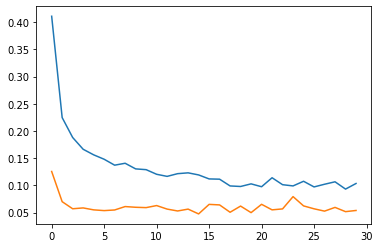

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


In [ ]:
model_ula.compile(loss='mse', optimizer=Adam(0.0001))
history = model_ula.fit(x_train_new , y_train_new, batch_size=1024, epochs=30, validation_data=(x_val , y_val), verbose=1)

Epoch 1/30
56/56 [==============================] - 2s 23ms/step - loss: 0.0924 - val_loss: 0.0512
Epoch 2/30
56/56 [==============================] - 1s 20ms/step - loss: 0.0818 - val_loss: 0.0483
Epoch 3/30
56/56 [==============================] - 1s 20ms/step - loss: 0.0849 - val_loss: 0.0482
Epoch 4/30
56/56 [==============================] - 1s 20ms/step - loss: 0.0841 - val_loss: 0.0483
Epoch 5/30
56/56 [==============================] - 1s 20ms/step - loss: 0.0824 - val_loss: 0.0481
Epoch 6/30
56/56 [==============================] - 1s 20ms/step - loss: 0.0831 - val_loss: 0.0480
Epoch 7/30
56/56 [==============================] - 1s 20ms/step - loss: 0.0834 - val_loss: 0.0473
Epoch 8/30
56/56 [==============================] - 1s 21ms/step - loss: 0.0869 - val_loss: 0.0469
Epoch 9/30
56/56 [==============================] - 1s 20ms/step - loss: 0.0764 - val_loss: 0.0471
Epoch 10/30
56/56 [==============================] - 1s 20ms/step - loss: 0.0880 - val_loss: 0.0477
Epoch 11/

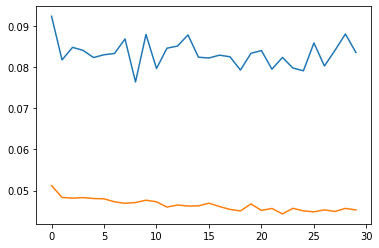

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
predict = model_ula.predict(x_test)

In [ ]:
predict_inverse = y_scaler.inverse_transform(predict).flatten()

In [ ]:
yTrainReal = y_scaler.inverse_transform(y_test_scaled).flatten()

In [ ]:
yTrainReal[1]

150000.0

In [ ]:
predict_inverse[1]

178767.88

In [ ]:
delta = yTrainReal - predict_inverse
abs_delta = abs(delta)
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(yTrainReal)/len(yTrainReal)
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

Средняя ошибка:  73078
Средняя цена:  535904
Процент ошибки: 14%
